In [60]:
import pandas as pd
import torch
from torch import nn
from transformers import AutoConfig, AutoTokenizer, AutoModel

seed = 42
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [61]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
!cp /kaggle/input/files-for-train/train.py /kaggle/working/

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [63]:
!git clone https://github.com/dml-qom/FarsTail.git data/FarsTail

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
fatal: destination path 'data/FarsTail' already exists and is not an empty directory.


In [64]:
from IPython import display
def rtl_print(outputs, font_size="15px", n_to_br=False):
    outputs = outputs if isinstance(outputs, list) else [outputs] 
    if n_to_br:
        outputs = [output.replace('\n', '') for output in outputs]
        
    outputs = [f'{output}' for output in outputs]
    display.display(display.HTML(' '.join(outputs)))

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix


def compute_loss(y, predictions, loss):
    # loss
    # binarize predictions from predictions (outputs = 1 if p>0.5 else 0)
    outputs = torch.argmax(predictions, axis=1)
    # metrics with accuracy, precision, recall, f1
    accuracy = accuracy_score(y.cpu(), outputs.cpu())
    precision, recall, f1 = [metric(y.cpu(), outputs.cpu(), average="micro") for metric in [precision_score, recall_score, f1_score]]
    return loss, accuracy, precision, recall, f1
    
def evaluate_loader(loader, model, criterion, device):
    # compute loss and accuracy for that loader
    metrics = {
        "loss": 0,
        "accuracy": 0,
        "precision": 0,
        "recall": 0,
        "f1": 0,
    }
    with torch.no_grad():
        # loop over examples of loader
        for i, data in enumerate(loader):

            input_ids = data["input_ids"].to(device)
            attention_mask = data["attention_mask"].to(device)
            token_type_ids = data["token_type_ids"].to(device)
            label_id = data["label_id"].to(device)
            logits, probs = model(input_ids, attention_mask, token_type_ids)
            loss = criterion(logits, label_id)
            loss, accuracy, precision, recall, f1 = compute_loss(label_id, logits, loss)
            # sum up metrics in dict
            metrics["loss"] += loss.item()
            metrics["accuracy"] += accuracy
            metrics["precision"] += precision
            metrics["recall"] += recall
            metrics["f1"] += f1
        # normalize all values
        for k in metrics.keys():
            metrics[k] /= len(loader)
        return metrics

def show_cm(model, loader, device):
    y_true, y_pred = [], []
    with torch.no_grad():
        for i, data in enumerate(loader):

            input_ids = data["input_ids"].to(device)
            attention_mask = data["attention_mask"].to(device)
            token_type_ids = data["token_type_ids"].to(device)
            label_id = data["label_id"].to(device)
            now_batch_size = label_id.size(0)
            logits, probs = model(input_ids, attention_mask, token_type_ids)
            outputs = torch.argmax(logits, axis=1)
            y_true.extend(label_id.tolist())
            y_pred.extend(outputs.tolist())
    cm = confusion_matrix(y_true, y_pred)
    return cm

In [65]:
with torch.no_grad():
    metrics = evaluate_loader(test_loader, model, criterion, device)
    cm = show_cm(model, test_loader, device)

for key, val in metrics.items():
    print(key, val)

print(cm)

loss 0.9735488733466791
accuracy 0.5092018950437318
precision 0.5092018950437318
recall 0.5092018950437318
f1 0.5092018950437318
[[115 353  42]
 [ 51 445  23]
 [ 80 219 236]]


In [66]:
train_df = pd.read_csv('./data/FarsTail/data/Train-word.csv', sep='\t')
val_df = pd.read_csv('./data/FarsTail/data/Val-word.csv', sep='\t')
test_df = pd.read_csv('./data/FarsTail/data/Test-word.csv', sep='\t')

In [67]:
train_df.head()

,premise,hypothesis,label
0,اولین انتقال و نفوذ طبیعی فرهنگ و تمدن اسلامی ...,نخستین انتقال و نفوذ طبیعی فرهنگ و تمدن اسلامی...,e
1,اولین انتقال و نفوذ طبیعی فرهنگ و تمدن اسلامی ...,کانون های جغرافیایی مصر، اندلس و شام، نخستین ر...,c
2,اولین انتقال و نفوذ طبیعی فرهنگ و تمدن اسلامی ...,سیسیل بعد از اسپانیا بزرگ ترین کانونی بود که ه...,n
3,ویژگی های هنر عصر اموی: ۱- تلفیقی بودن ۲- بازن...,نقاشی های تزئینی و تندیس های بی‌کیفیت، یکی از ...,e
4,ویژگی های هنر عصر اموی: ۱- تلفیقی بودن ۲- بازن...,با کیفیت بودن تندیس های دوره اموی، یکی از ویژگ...,c


In [68]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_df['label_id'] = label_encoder.fit_transform(train_df['label'])
val_df['label_id'] = label_encoder.transform(val_df['label'])
test_df['label_id'] = label_encoder.transform(test_df['label'])

In [69]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer):
        self.df = df
        self.tokenizer = tokenizer
        self.max_length = 50

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        # x = torch.tensor(row['text'], dtype=torch.float32)
        premise = row["premise"]
        hypothesis = row["hypothesis"]
        label = row["label"]
        label_id = row["label_id"]
        # text = f"{self.tokenizer.cls_token} {premise} {self.tokenizer.sep_token} {hypothesis} {self.tokenizer.sep_token}"
        # Tokenize inputs
        encoded_inputs = self.tokenizer.encode_plus(
            premise,
            hypothesis,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt",
        )
        input_ids = encoded_inputs["input_ids"].squeeze()
        attention_mask = encoded_inputs["attention_mask"].squeeze()
        token_type_id = encoded_inputs["token_type_ids"].squeeze()
        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "token_type_ids": token_type_id,
            "label": label,
            "label_id": torch.tensor(label_id, dtype=torch.long),
        }

attention mask  
https://huggingface.co/transformers/v3.2.0/glossary.html#attention-mask  
token type id  
https://huggingface.co/transformers/v3.2.0/glossary.html#token-type-ids  

In [70]:

# config = AutoConfig.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")
tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")
# model = AutoModel.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")
# model = model.to(device)



In [71]:
from multiprocessing import cpu_count

train_dataset = Dataset(train_df, tokenizer)
val_dataset = Dataset(val_df, tokenizer)
test_dataset = Dataset(test_df, tokenizer)


batch_size = 32
num_workers = cpu_count() - 2
pin_memory = True if device == "cuda" else False
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

In [72]:
# from transformers import *
# from utils.utils import build_batch


class BertNLIModel(nn.Module):
    def __init__(
        self,
        label_num=3,
        reinit_num=0,
        encoder_layer=12,
        freeze_layers=True,
    ):
        super(BertNLIModel, self).__init__()
        # self.bert = BertModel.from_pretrained('bert-base-uncased')
        # self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

        self.config = AutoConfig.from_pretrained(
            "HooshvareLab/bert-base-parsbert-uncased"
        )
        # self.tokenizer = AutoTokenizer.from_pretrained(
        #     "HooshvareLab/bert-base-parsbert-uncased"
        # )
        self.bert = AutoModel.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")
        self.bert.encoder.layer = self.bert.encoder.layer[:encoder_layer]

        self.num_hidden_layers = self.config.num_hidden_layers
        self.vdim = self.config.hidden_size
        self.encoder_layer = encoder_layer

        self.nli_head1 = nn.Linear(self.vdim, 250)
        self.nli_head2 = nn.Linear(250, label_num)
        self.sm = nn.Softmax(dim=1)
        self.reinit(freeze=freeze_layers)

    def reinit(self, freeze):
        if freeze:
            for _, pp in self.bert.named_parameters():
                pp.requires_grad = False

    def forward(self, input_ids, attention_mask, token_type_ids):
        cls_vecs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
        )[1]

        logits = self.nli_head1(cls_vecs)
        logits = self.nli_head2(logits)
        probs = self.sm(logits)

        torch.cuda.empty_cache()  # releases all unoccupied cached memory

        return logits, probs

    def _get_name(self):
        return f"{super()._get_name()}-{self.encoder_layer}"

    def __str__(self) -> str:
        return f"BertNLIModel-Encoder-{self.encoder_layer}"

    def __repr__(self):
        return f"BertNLIModel-Encoder-{self.encoder_layer}"

In [73]:
data = next(iter(train_loader))

input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
token_type_ids = data['token_type_ids'].to(device)
label_id = data['label_id'].to(device)

In [74]:
from train import train
from easydict import EasyDict

dataset = EasyDict(
    {
        "train": train_dataset,
        "val": test_dataset,
        "test": test_dataset,
    }
)
data_loader = EasyDict(
    {
        "train": train_loader,
        "val": test_loader,
        "test": test_loader,
    }
)

In [75]:
model = BertNLIModel(label_num=3, encoder_layer=12)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(),lr=2e-4,eps=1e-6)

start = train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    data_loader=data_loader,
    dataset=dataset,
    device=device,
    epochs=40,
)

Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


model/state-BertNLIModel-12-optimizer-AdamW-loss-CrossEntropyLoss.pth exist


In [76]:
with torch.no_grad():
    metrics = evaluate_loader(test_loader, model, criterion, device)
    cm = show_cm(model, test_loader, device)

for key, val in metrics.items():
    print(key, val)

print(cm)

loss 1.010327190768962
accuracy 0.4968112244897959
precision 0.4968112244897959
recall 0.4968112244897959
f1 0.4968112244897959
[[237 247  26]
 [125 378  16]
 [200 173 162]]


In [77]:
model = BertNLIModel(label_num=3, encoder_layer=11)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(),lr=2e-4,eps=1e-6)

start = train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    data_loader=data_loader,
    dataset=dataset,
    device=device,
    epochs=40,
)

Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


model/state-BertNLIModel-11-optimizer-AdamW-loss-CrossEntropyLoss.pth exist


In [78]:

with torch.no_grad():
    metrics = evaluate_loader(test_loader, model, criterion, device)
    cm = show_cm(model, test_loader, device)

for key, val in metrics.items():
    print(key, val)

print(cm)

loss 0.9735488733466791
accuracy 0.5092018950437318
precision 0.5092018950437318
recall 0.5092018950437318
f1 0.5092018950437318
[[115 353  42]
 [ 51 445  23]
 [ 80 219 236]]


Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


model/state-BertNLIModel-10-optimizer-AdamW-loss-CrossEntropyLoss.pth Not exist


### BETTER NET STATE ###
[20s] Epoch 1 loss : 1.05635272 acc: 43.28 val: 1.01572782 acc: 46.42%


### BETTER NET STATE ###
[19s] Epoch 2 loss : 1.02081773 acc: 46.89 val: 0.98604434 acc: 49.81%


[19s] Epoch 3 loss : 1.00351968 acc: 48.62 val: 0.98992617 acc: 48.79%


[19s] Epoch 4 loss : 0.99776507 acc: 48.84 val: 0.99929285 acc: 47.25%


### BETTER NET STATE ###
[19s] Epoch 5 loss : 0.99125056 acc: 49.35 val: 0.96574196 acc: 50.38%


[19s] Epoch 6 loss : 0.98177053 acc: 50.62 val: 0.96620580 acc: 49.87%


[19s] Epoch 7 loss : 0.97300326 acc: 51.2 val: 1.04361939 acc: 44.82%


### BETTER NET STATE ###
[19s] Epoch 8 loss : 0.97918081 acc: 50.61 val: 0.93987500 acc: 52.94%


[19s] Epoch 9 loss : 0.97285526 acc: 51.16 val: 0.95581357 acc: 51.85%


[19s] Epoch 10 loss : 0.98232473 acc: 51.1 val: 1.14810149 acc: 40.03%


### BETTER NET STATE ###
[19s] Epoch 11 loss : 0.98568007 acc: 49.96 val: 0.93052695 acc: 54.16%


[19s] Epoch 12 loss : 0.97430029 acc: 51.51 val: 0.96638522 acc: 50.9%


[19s] Epoch 13 loss : 0.96947633 acc: 51.69 val: 0.95079211 acc: 52.37%


### BETTER NET STATE ###
[19s] Epoch 14 loss : 0.97330665 acc: 51.21 val: 0.93019055 acc: 53.52%


[19s] Epoch 15 loss : 0.95945231 acc: 51.49 val: 0.95460771 acc: 50.58%


### BETTER NET STATE ###
[19s] Epoch 16 loss : 0.96223084 acc: 51.82 val: 0.92689015 acc: 53.64%


### BETTER NET STATE ###
[19s] Epoch 17 loss : 0.95837280 acc: 51.47 val: 0.91939285 acc: 55.95%


[19s] Epoch 18 loss : 0.96543202 acc: 52.13 val: 0.96485775 acc: 50.58%


### BETTER NET STATE ###
[19s] Epoch 19 loss : 0.95700941 acc: 51.82 val: 0.91098932 acc: 54.92%


[19s] Epoch 20 loss : 0.95703914 acc: 51.6 val: 0.93098021 acc: 54.03%


[19s] Epoch 21 loss : 0.95238008 acc: 53.07 val: 0.93926860 acc: 52.62%


[19s] Epoch 22 loss : 0.95122537 acc: 52.95 val: 0.95578420 acc: 50.64%


[19s] Epoch 23 loss : 0.95477595 acc: 52.53 val: 0.93195858 acc: 52.75%


[19s] Epoch 24 loss : 0.95311933 acc: 52.31 val: 0.93092965 acc: 51.34%


[19s] Epoch 25 loss : 0.95137667 acc: 52.6 val: 0.92759221 acc: 52.56%


[19s] Epoch 26 loss : 0.95672711 acc: 52.49 val: 0.99444004 acc: 48.85%


[19s] Epoch 27 loss : 0.95218239 acc: 52.6 val: 1.00398929 acc: 48.98%


[19s] Epoch 28 loss : 0.95251507 acc: 52.66 val: 0.91760219 acc: 53.71%


[19s] Epoch 29 loss : 0.94248478 acc: 53.54 val: 1.02173233 acc: 47.63%


[19s] Epoch 30 loss : 0.94558810 acc: 53.11 val: 1.01892668 acc: 48.72%


[19s] Epoch 31 loss : 0.95116211 acc: 53.01 val: 0.92366533 acc: 52.81%


[19s] Epoch 32 loss : 0.95245244 acc: 52.16 val: 0.91489573 acc: 54.41%


[19s] Epoch 33 loss : 0.95199927 acc: 52.74 val: 0.95505609 acc: 50.83%


[19s] Epoch 34 loss : 0.94544114 acc: 53.19 val: 0.97619526 acc: 50.58%


### BETTER NET STATE ###
[20s] Epoch 35 loss : 0.94054420 acc: 53.76 val: 0.90999319 acc: 55.56%


[19s] Epoch 36 loss : 0.94691339 acc: 53.15 val: 0.92702111 acc: 53.07%


### BETTER NET STATE ###
[19s] Epoch 37 loss : 0.94974141 acc: 53.14 val: 0.90387385 acc: 56.52%


[19s] Epoch 38 loss : 0.94531747 acc: 52.88 val: 0.90751772 acc: 54.6%


### BETTER NET STATE ###
[19s] Epoch 39 loss : 0.93738445 acc: 53.48 val: 0.90375755 acc: 55.56%


[20s] Epoch 40 loss : 0.95393594 acc: 52.46 val: 0.90638006 acc: 56.27%


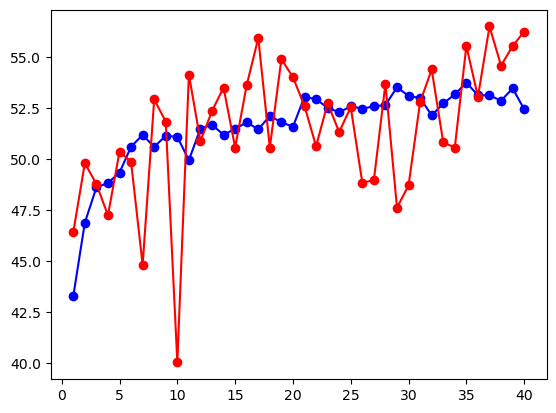

In [79]:
model = BertNLIModel(label_num=3, encoder_layer=10)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(),lr=2e-4,eps=1e-6)

start = train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    data_loader=data_loader,
    dataset=dataset,
    device=device,
    epochs=40,
)

In [80]:

with torch.no_grad():
    metrics = evaluate_loader(test_loader, model, criterion, device)
    cm = show_cm(model, test_loader, device)

for key, val in metrics.items():
    print(key, val)

print(cm)

loss 0.9057616080556598
accuracy 0.5627733236151604
precision 0.5627733236151604
recall 0.5627733236151604
f1 0.5627733236151604
[[111 232 167]
 [ 56 357 106]
 [ 40  83 412]]


Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


model/state-BertNLIModel-9-optimizer-AdamW-loss-CrossEntropyLoss.pth Not exist


### BETTER NET STATE ###
[19s] Epoch 1 loss : 1.06029484 acc: 43.16 val: 1.06426023 acc: 43.61%


[19s] Epoch 2 loss : 1.02406675 acc: 46.38 val: 1.06873290 acc: 43.48%


### BETTER NET STATE ###
[19s] Epoch 3 loss : 1.01521582 acc: 47.48 val: 1.00039329 acc: 48.79%


[18s] Epoch 4 loss : 0.99079678 acc: 49.06 val: 1.02814229 acc: 46.16%


### BETTER NET STATE ###
[19s] Epoch 5 loss : 0.99551769 acc: 48.5 val: 0.95733676 acc: 51.09%


[19s] Epoch 6 loss : 0.99165409 acc: 49.71 val: 0.96672402 acc: 50.06%


[18s] Epoch 7 loss : 0.97844664 acc: 50.37 val: 0.96677666 acc: 51.92%


### BETTER NET STATE ###
[19s] Epoch 8 loss : 0.99287283 acc: 49.71 val: 0.94623084 acc: 51.15%


[19s] Epoch 9 loss : 0.98364366 acc: 50.01 val: 0.99764416 acc: 48.34%


[19s] Epoch 10 loss : 0.97973593 acc: 50.95 val: 0.96302441 acc: 51.85%


[19s] Epoch 11 loss : 0.97321340 acc: 50.61 val: 0.97799701 acc: 50.26%


[19s] Epoch 12 loss : 0.98691222 acc: 50.36 val: 0.95383441 acc: 52.49%


### BETTER NET STATE ###
[19s] Epoch 13 loss : 0.98171715 acc: 50.03 val: 0.92776003 acc: 54.73%


[18s] Epoch 14 loss : 0.96725671 acc: 51.39 val: 0.96014041 acc: 49.94%


[18s] Epoch 15 loss : 0.97661574 acc: 50.36 val: 0.98330134 acc: 49.42%


[18s] Epoch 16 loss : 0.97780646 acc: 50.67 val: 0.97217193 acc: 49.62%


[18s] Epoch 17 loss : 0.97298694 acc: 50.26 val: 0.94067758 acc: 52.37%


### BETTER NET STATE ###
[19s] Epoch 18 loss : 0.96705222 acc: 51.84 val: 0.92471821 acc: 54.48%


[18s] Epoch 19 loss : 0.96346793 acc: 51.27 val: 0.92492666 acc: 54.35%


[18s] Epoch 20 loss : 0.96619399 acc: 51.06 val: 0.94211564 acc: 52.11%


[18s] Epoch 21 loss : 0.97574412 acc: 50.36 val: 0.93767077 acc: 50.64%


### BETTER NET STATE ###
[19s] Epoch 22 loss : 0.96655862 acc: 51.98 val: 0.92419768 acc: 53.39%


[19s] Epoch 23 loss : 0.96684289 acc: 50.8 val: 0.93502852 acc: 53.58%


### BETTER NET STATE ###
[18s] Epoch 24 loss : 0.97093012 acc: 51.31 val: 0.92367209 acc: 52.56%


### BETTER NET STATE ###
[19s] Epoch 25 loss : 0.96974192 acc: 51.9 val: 0.92292042 acc: 54.54%


[18s] Epoch 26 loss : 0.95843957 acc: 52.42 val: 0.99081548 acc: 51.6%


[19s] Epoch 27 loss : 0.96864330 acc: 51.8 val: 0.95696670 acc: 51.47%


[19s] Epoch 28 loss : 0.96696242 acc: 51.94 val: 0.94974940 acc: 51.02%


[18s] Epoch 29 loss : 0.96040760 acc: 51.64 val: 0.98135448 acc: 51.79%


[19s] Epoch 30 loss : 0.96402652 acc: 51.97 val: 0.93035337 acc: 53.84%


[18s] Epoch 31 loss : 0.96007668 acc: 51.65 val: 0.99745098 acc: 48.4%


[19s] Epoch 32 loss : 0.95755592 acc: 52.29 val: 1.09561958 acc: 45.78%


[18s] Epoch 33 loss : 0.96552071 acc: 51.51 val: 0.97273232 acc: 51.47%


### BETTER NET STATE ###
[18s] Epoch 34 loss : 0.96122249 acc: 51.47 val: 0.92118931 acc: 53.13%


[19s] Epoch 35 loss : 0.96097641 acc: 51.83 val: 0.92376170 acc: 53.96%


[18s] Epoch 36 loss : 0.95859677 acc: 52.16 val: 0.92244578 acc: 53.13%


[19s] Epoch 37 loss : 0.95339177 acc: 52.06 val: 0.92469029 acc: 55.63%


[18s] Epoch 38 loss : 0.95975328 acc: 52.52 val: 0.93411598 acc: 52.24%


### BETTER NET STATE ###
[19s] Epoch 39 loss : 0.94808803 acc: 53.06 val: 0.91975277 acc: 56.07%


### BETTER NET STATE ###
[19s] Epoch 40 loss : 0.96292332 acc: 52.16 val: 0.91186182 acc: 54.6%


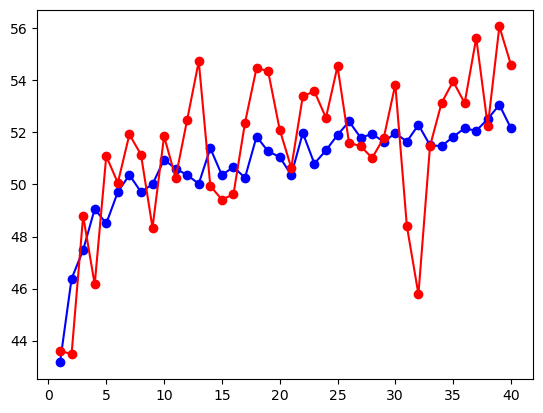

In [81]:
model = BertNLIModel(label_num=3, encoder_layer=9)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(),lr=2e-4,eps=1e-6)

start = train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    data_loader=data_loader,
    dataset=dataset,
    device=device,
    epochs=40,
)

In [82]:

with torch.no_grad():
    metrics = evaluate_loader(test_loader, model, criterion, device)
    cm = show_cm(model, test_loader, device)

for key, val in metrics.items():
    print(key, val)

print(cm)

loss 0.9112565067349648
accuracy 0.5458272594752187
precision 0.5458272594752187
recall 0.5458272594752187
f1 0.5458272594752187
[[147 249 114]
 [ 90 368  61]
 [ 94 102 339]]


Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


model/state-BertNLIModel-8-optimizer-AdamW-loss-CrossEntropyLoss.pth Not exist


### BETTER NET STATE ###
[18s] Epoch 1 loss : 1.05158710 acc: 43.9 val: 1.04821010 acc: 46.74%


### BETTER NET STATE ###
[17s] Epoch 2 loss : 1.01837046 acc: 47.55 val: 0.99869881 acc: 50.0%


### BETTER NET STATE ###
[18s] Epoch 3 loss : 1.00005780 acc: 48.77 val: 0.98209852 acc: 50.58%


[17s] Epoch 4 loss : 0.99080119 acc: 49.12 val: 0.99146067 acc: 47.44%


### BETTER NET STATE ###
[18s] Epoch 5 loss : 0.98999139 acc: 49.93 val: 0.96891087 acc: 50.7%


### BETTER NET STATE ###
[17s] Epoch 6 loss : 0.98468469 acc: 49.41 val: 0.95330202 acc: 51.98%


[17s] Epoch 7 loss : 0.98434365 acc: 50.07 val: 0.99171750 acc: 49.49%


[17s] Epoch 8 loss : 0.97777466 acc: 50.23 val: 0.96170621 acc: 49.3%


### BETTER NET STATE ###
[17s] Epoch 9 loss : 0.97835470 acc: 50.51 val: 0.93304269 acc: 53.2%


[17s] Epoch 10 loss : 0.97536540 acc: 50.17 val: 1.04274304 acc: 46.23%


### BETTER NET STATE ###
[17s] Epoch 11 loss : 0.98140454 acc: 49.53 val: 0.93112734 acc: 54.22%


[17s] Epoch 12 loss : 0.98120323 acc: 50.06 val: 0.94351542 acc: 52.69%


[17s] Epoch 13 loss : 0.98091494 acc: 50.25 val: 1.00016000 acc: 51.02%


[17s] Epoch 14 loss : 0.97591414 acc: 50.77 val: 0.96744357 acc: 50.0%


[17s] Epoch 15 loss : 0.97136589 acc: 50.91 val: 0.93456584 acc: 51.92%


[17s] Epoch 16 loss : 0.97252023 acc: 51.23 val: 1.00643287 acc: 49.23%


[17s] Epoch 17 loss : 0.97598599 acc: 50.21 val: 0.96225931 acc: 51.15%


[17s] Epoch 18 loss : 0.96475428 acc: 51.78 val: 0.93965812 acc: 53.26%


[17s] Epoch 19 loss : 0.96851809 acc: 51.27 val: 0.98837491 acc: 49.62%


[18s] Epoch 20 loss : 0.97018810 acc: 51.4 val: 0.93381266 acc: 52.17%


[18s] Epoch 21 loss : 0.97571938 acc: 51.47 val: 0.99168253 acc: 50.64%


[17s] Epoch 22 loss : 0.96283165 acc: 51.72 val: 1.00746326 acc: 50.26%


### BETTER NET STATE ###
[18s] Epoch 23 loss : 0.97175325 acc: 51.28 val: 0.92571536 acc: 52.94%


[17s] Epoch 24 loss : 0.96811361 acc: 51.6 val: 0.97330769 acc: 50.64%


### BETTER NET STATE ###
[18s] Epoch 25 loss : 0.96329491 acc: 51.54 val: 0.91638749 acc: 54.86%


[17s] Epoch 26 loss : 0.96418968 acc: 51.89 val: 0.92413012 acc: 55.31%


[18s] Epoch 27 loss : 0.96172403 acc: 51.98 val: 0.92368007 acc: 52.75%


[18s] Epoch 28 loss : 0.95757547 acc: 51.8 val: 1.01099047 acc: 48.02%


[17s] Epoch 29 loss : 0.96230249 acc: 51.6 val: 0.94175870 acc: 53.32%


[18s] Epoch 30 loss : 0.95909680 acc: 52.44 val: 1.02048408 acc: 49.23%


[17s] Epoch 31 loss : 0.96394224 acc: 52.13 val: 0.94110937 acc: 53.58%


### BETTER NET STATE ###
[18s] Epoch 32 loss : 0.95903287 acc: 51.53 val: 0.91145145 acc: 55.56%


[17s] Epoch 33 loss : 0.96091654 acc: 51.76 val: 0.91498483 acc: 56.52%


[17s] Epoch 34 loss : 0.95471808 acc: 52.75 val: 0.93445969 acc: 53.45%


[17s] Epoch 35 loss : 0.96982048 acc: 51.79 val: 0.91286715 acc: 55.95%


[18s] Epoch 36 loss : 0.96062199 acc: 52.24 val: 0.91837437 acc: 53.26%


[18s] Epoch 37 loss : 0.94368869 acc: 53.29 val: 0.95809166 acc: 52.88%


[17s] Epoch 38 loss : 0.96389429 acc: 52.23 val: 0.96255343 acc: 49.81%


[18s] Epoch 39 loss : 0.96180113 acc: 52.26 val: 0.95116203 acc: 51.28%


[18s] Epoch 40 loss : 0.96072903 acc: 52.29 val: 0.92152713 acc: 53.39%


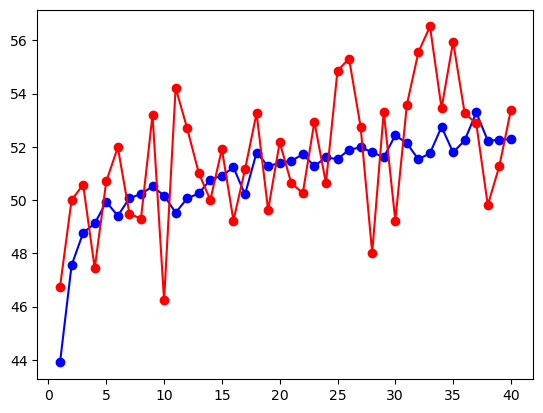

In [83]:
model = BertNLIModel(label_num=3, encoder_layer=8)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(),lr=2e-4,eps=1e-6)

start = train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    data_loader=data_loader,
    dataset=dataset,
    device=device,
    epochs=40,
)

In [84]:

with torch.no_grad():
    metrics = evaluate_loader(test_loader, model, criterion, device)
    cm = show_cm(model, test_loader, device)

for key, val in metrics.items():
    print(key, val)

print(cm)

loss 0.9208594183532559
accuracy 0.5338921282798834
precision 0.5338921282798834
recall 0.5338921282798834
f1 0.5338921282798834
[[117 293 100]
 [ 64 405  50]
 [ 81 141 313]]


Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


model/state-BertNLIModel-7-optimizer-AdamW-loss-CrossEntropyLoss.pth Not exist


### BETTER NET STATE ###
[16s] Epoch 1 loss : 1.04195246 acc: 44.25 val: 1.03390777 acc: 44.57%


### BETTER NET STATE ###
[17s] Epoch 2 loss : 1.01330111 acc: 47.16 val: 0.97858396 acc: 52.24%


### BETTER NET STATE ###
[16s] Epoch 3 loss : 1.01725329 acc: 46.72 val: 0.97764064 acc: 50.58%


[17s] Epoch 4 loss : 1.00070656 acc: 48.91 val: 0.97983090 acc: 49.62%


### BETTER NET STATE ###
[16s] Epoch 5 loss : 1.00676524 acc: 48.36 val: 0.95567817 acc: 52.81%


### BETTER NET STATE ###
[17s] Epoch 6 loss : 0.99486267 acc: 49.19 val: 0.95465206 acc: 53.07%


### BETTER NET STATE ###
[16s] Epoch 7 loss : 0.98984659 acc: 49.11 val: 0.94975819 acc: 51.34%


### BETTER NET STATE ###
[17s] Epoch 8 loss : 0.98316576 acc: 50.95 val: 0.94648425 acc: 52.3%


[16s] Epoch 9 loss : 0.98016795 acc: 50.89 val: 0.96700774 acc: 49.94%


[17s] Epoch 10 loss : 0.98210994 acc: 50.34 val: 0.95324030 acc: 51.28%


### BETTER NET STATE ###
[16s] Epoch 11 loss : 0.97610024 acc: 51.24 val: 0.93359045 acc: 55.5%


### BETTER NET STATE ###
[16s] Epoch 12 loss : 0.97668888 acc: 50.83 val: 0.93178610 acc: 55.31%


[16s] Epoch 13 loss : 0.97620783 acc: 50.74 val: 0.93485130 acc: 54.67%


[17s] Epoch 14 loss : 0.97266109 acc: 50.8 val: 0.94212843 acc: 53.26%


[16s] Epoch 15 loss : 0.96898012 acc: 51.75 val: 0.94299990 acc: 51.34%


### BETTER NET STATE ###
[17s] Epoch 16 loss : 0.96869086 acc: 51.09 val: 0.93037922 acc: 53.32%


[17s] Epoch 17 loss : 0.97064513 acc: 51.27 val: 0.93155347 acc: 53.77%


[17s] Epoch 18 loss : 0.97471650 acc: 51.4 val: 0.97861992 acc: 49.42%


### BETTER NET STATE ###
[17s] Epoch 19 loss : 0.97357264 acc: 50.7 val: 0.92631258 acc: 53.58%


[16s] Epoch 20 loss : 0.97125768 acc: 51.0 val: 0.94542887 acc: 51.47%


[17s] Epoch 21 loss : 0.97295980 acc: 51.18 val: 0.94899494 acc: 51.09%


[16s] Epoch 22 loss : 0.96583055 acc: 51.1 val: 0.96124397 acc: 52.88%


### BETTER NET STATE ###
[17s] Epoch 23 loss : 0.96205718 acc: 51.45 val: 0.92202185 acc: 53.58%


[17s] Epoch 24 loss : 0.97325182 acc: 51.07 val: 0.97529508 acc: 52.17%


### BETTER NET STATE ###
[17s] Epoch 25 loss : 0.96335371 acc: 51.64 val: 0.91933931 acc: 55.82%


[16s] Epoch 26 loss : 0.97311091 acc: 51.36 val: 0.94729154 acc: 51.15%


[17s] Epoch 27 loss : 0.96377478 acc: 52.19 val: 0.92018386 acc: 54.03%


### BETTER NET STATE ###
[17s] Epoch 28 loss : 0.96283563 acc: 51.67 val: 0.91918224 acc: 55.43%


[17s] Epoch 29 loss : 0.96823196 acc: 51.25 val: 0.92698741 acc: 54.54%


### BETTER NET STATE ###
[16s] Epoch 30 loss : 0.96059286 acc: 52.41 val: 0.91602245 acc: 55.31%


[17s] Epoch 31 loss : 0.96253616 acc: 51.64 val: 0.92942723 acc: 53.13%


[16s] Epoch 32 loss : 0.97314141 acc: 50.63 val: 0.95611718 acc: 52.94%


[17s] Epoch 33 loss : 0.96561420 acc: 52.44 val: 0.92110614 acc: 53.01%


[16s] Epoch 34 loss : 0.96405183 acc: 52.15 val: 0.92995133 acc: 54.6%


[17s] Epoch 35 loss : 0.94846419 acc: 53.44 val: 0.91604771 acc: 55.82%


[17s] Epoch 36 loss : 0.95630450 acc: 52.23 val: 0.91623697 acc: 55.31%


[16s] Epoch 37 loss : 0.96242739 acc: 51.75 val: 0.91826451 acc: 56.2%


[17s] Epoch 38 loss : 0.96122752 acc: 51.39 val: 0.96579365 acc: 50.13%


[16s] Epoch 39 loss : 0.96481975 acc: 52.34 val: 0.92118733 acc: 52.81%


[17s] Epoch 40 loss : 0.96735233 acc: 52.05 val: 0.91949840 acc: 53.77%


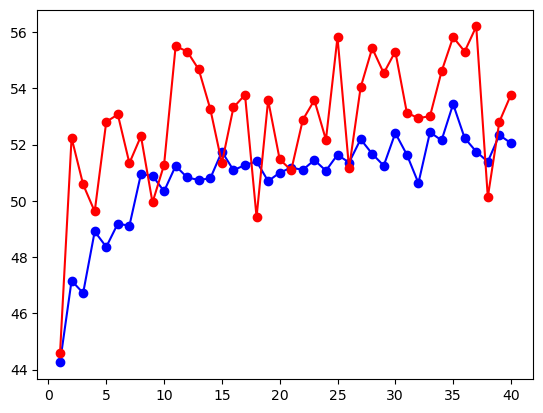

In [85]:
model = BertNLIModel(label_num=3, encoder_layer=7)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(),lr=2e-4,eps=1e-6)

start = train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    data_loader=data_loader,
    dataset=dataset,
    device=device,
    epochs=40,
)

In [86]:

with torch.no_grad():
    metrics = evaluate_loader(test_loader, model, criterion, device)
    cm = show_cm(model, test_loader, device)

for key, val in metrics.items():
    print(key, val)

print(cm)

loss 0.9188025435622857
accuracy 0.5376275510204082
precision 0.5376275510204082
recall 0.5376275510204082
f1 0.5376275510204082
[[ 46 280 184]
 [ 24 380 115]
 [ 20 100 415]]


In [87]:
!zip -r dl.zip model loss_graph

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
	zip warning: name not matched: loss_graph
  adding: model/ (stored 0%)
  adding: model/state-BertNLIModel-7-optimizer-AdamW-loss-CrossEntropyLoss.pth (deflated 8%)
  adding: model/state-BertNLIModel-10-optimizer-AdamW-loss-CrossEntropyLoss.pth (deflated 8%)
  adding: model/state-BertNLIModel-12-optimizer-AdamW-loss-CrossEntropyLoss.pth (deflated 8%)
  adding: model/state-BertNLIModel-11-optimizer-AdamW-loss-CrossEntropyLoss.pth (deflated 8%)
  adding: model/state-BertNLIModel-8-optimizer-AdamW-loss-CrossEntropyLoss.pth (deflated 8%)
  adding: model/state-BertNLIModel-9-optimizer-AdamW-loss-CrossEntropyLoss.pth (deflated 8%)


In [88]:
!zip -r dl_graph.zip loss_graphs

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  adding: loss_graphs/ (stored 0%)
  adding: loss_graphs/train_loss_BertNLIModel-10-AdamW_CrossEntropyLoss.jpg (deflated 24%)
  adding: loss_graphs/train_loss_BertNLIModel-7-AdamW_CrossEntropyLoss.jpg (deflated 22%)
  adding: loss_graphs/train_acc_BertNLIModel-10-AdamW_CrossEntropyLoss.jpg (deflated 22%)
  adding: loss_graphs/train_acc_BertNLIModel-9-AdamW_CrossEntropyLoss.jpg (deflated 23%)
  adding: loss_graphs/train_loss_BertNLIModel-12-AdamW_CrossEntropyLoss.jpg (deflated 23%)
  adding: loss_graphs/train_acc_BertNLIModel-12-AdamW_CrossEntropyLoss.jpg (deflated 24%)
  adding: loss_graphs/train_loss_BertNLIModel-11-AdamW_CrossEntropyLoss.jpg (deflated 20%)
  adding: